# Importing Packages

In [124]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import re

from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


# Data Loading and Exploration

In [8]:
train_data = pd.read_csv("/kaggle/input/ag-news-classification-dataset/train.csv")
test_data = pd.read_csv("/kaggle/input/ag-news-classification-dataset/test.csv")

In [9]:
classes = {
    1 : "World",
    2 : "Sports",
    3 : "Business",
    4 : "Sci/Tech"
}

In [4]:
train_data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
test_data.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [7]:
train_data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [8]:
test_data.isnull().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [9]:
train_data.describe(include=['O'])

,Title,Description
count,120000,120000
unique,114350,118723
top,Today's schedule,"With the economy slowly turning up, upgrading ..."
freq,39,15


In [10]:
test_data.describe(include=['O'])

,Title,Description
count,7600,7600
unique,7568,7594
top,Today's schedule,WASHINGTON (Reuters) - The U.S. economy slowe...
freq,4,2


In [11]:
train_data["Class Index"].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [12]:
test_data["Class Index"].value_counts()

Class Index
3    1900
4    1900
2    1900
1    1900
Name: count, dtype: int64

# Data Cleaning and Preprocessing

In [13]:
train_data.duplicated().sum()

0

In [14]:
test_data.duplicated().sum()

0

In [10]:
lemmatizer = WordNetLemmatizer()
all_stopwords = set(stopwords.words("english"))
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("<.*?>", " ", sentence)
    sentence = re.sub("[^A-Za-z0-9]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    words = word_tokenize(sentence)
    cleaned_sentence = ""
    for word in words:
        if word not in all_stopwords:
            word = lemmatizer.lemmatize(word)
            cleaned_sentence += word + " "

    cleaned_sentence = cleaned_sentence.rstrip()
    return cleaned_sentence

In [16]:
preprocess_text("Ahmed is a    good boy !!@ff <br>")

'ahmed good boy ff'

In [11]:
train_data["title_preprocessed"] = train_data["Title"].apply(preprocess_text)

In [12]:
train_data["description_preprocessed"] = train_data["Description"].apply(preprocess_text)

In [13]:
test_data["title_preprocessed"] = test_data["Title"].apply(preprocess_text)

In [14]:
test_data["description_preprocessed"] = test_data["Description"].apply(preprocess_text)

In [15]:
train_data["text_preprocessed"] = train_data["title_preprocessed"] + train_data["description_preprocessed"]

In [16]:
train_data.head()

,Class Index,Title,Description,title_preprocessed,description_preprocessed,text_preprocessed
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st bear claw back black reuters,reuters short seller wall street dwindling ban...,wall st bear claw back black reutersreuters sh...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle look toward commercial aerospace reuters,reuters private investment firm carlyle group ...,carlyle look toward commercial aerospace reute...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stock outlook reuters,reuters soaring crude price plus worry economy...,oil economy cloud stock outlook reutersreuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halt oil export main southern pipeline re...,reuters authority halted oil export flow main ...,iraq halt oil export main southern pipeline re...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil price soar time record posing new menace u...,afp tearaway world oil price toppling record s...,oil price soar time record posing new menace u...


In [17]:
test_data["text_preprocessed"] = test_data["title_preprocessed"] + test_data["description_preprocessed"]

In [18]:
test_data.head()

,Class Index,Title,Description,title_preprocessed,description_preprocessed,text_preprocessed
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fear n pension talk,union representing worker turner newall say di...,fear n pension talkunion representing worker t...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",race second private team set launch date human...,space com toronto canada second team rocketeer...,race second private team set launch date human...
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ky company win grant study peptide ap,ap company founded chemistry researcher univer...,ky company win grant study peptide apap compan...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit help forecast wildfire ap,ap barely dawn mike fitzpatrick start shift bl...,prediction unit help forecast wildfire apap ba...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aim limit farm related smog ap,ap southern california smog fighting agency we...,calif aim limit farm related smog apap souther...


# TF-IDF Vectorizer

In [68]:
tfidf = TfidfVectorizer(
    ngram_range = (1,2),
    max_df = 0.9,
    min_df=5
)
train_conc_tfidf = tfidf.fit_transform(train_data["text_preprocessed"])
test_conc_tfidf = tfidf.transform(test_data["text_preprocessed"])

In [69]:
train_conc_tfidf.shape

(120000, 102650)

In [70]:
test_conc_tfidf.shape

(7600, 102650)

# Logistic Regression on TF-IDF

In [75]:
lr_model = LogisticRegression(max_iter = 10000)
lr_model.fit(train_conc_tfidf, train_data["Class Index"])

LogisticRegression(max_iter=10000)

In [76]:
y_pred_lr_tfidf = lr_model.predict(test_conc_tfidf)

In [78]:
accuracy_score(test_data["Class Index"], y_pred_lr_tfidf)

0.9175

In [79]:
print(classification_report(test_data["Class Index"], y_pred_lr_tfidf))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.89      0.88      0.88      1900
           4       0.90      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



# Random Forest on TF-IDF

In [82]:
rf_model = RandomForestClassifier()
rf_model.fit(train_conc_tfidf, train_data["Class Index"])

RandomForestClassifier()

In [83]:
y_pred_rf_tfidf = rf_model.predict(test_conc_tfidf)

In [84]:
accuracy_score(test_data["Class Index"], y_pred_rf_tfidf)

0.896578947368421

In [86]:
print(classification_report(test_data["Class Index"], y_pred_rf_tfidf))

              precision    recall  f1-score   support

           1       0.91      0.90      0.90      1900
           2       0.92      0.97      0.95      1900
           3       0.88      0.85      0.86      1900
           4       0.88      0.86      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



# SVM on TF-IDF

In [88]:
svm_model = LinearSVC()
svm_model.fit(train_conc_tfidf, train_data["Class Index"])

LinearSVC()

In [89]:
y_pred_svm_tfidf = svm_model.predict(test_conc_tfidf)

In [90]:
accuracy_score(test_data["Class Index"], y_pred_svm_tfidf)

0.9198684210526316

In [91]:
print(classification_report(test_data["Class Index"], y_pred_svm_tfidf))

              precision    recall  f1-score   support

           1       0.94      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.89      0.88      0.89      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



# Word Embeddings Using Qwen3-Embedding-0.6B 

In [19]:
embedder = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
train_conc_emb = embedder.encode(train_data["text_preprocessed"], batch_size = 32, show_progress_bar = True, convert_to_numpy = True)
test_conc_emb = embedder.encode(test_data["text_preprocessed"], batch_size = 32, show_progress_bar = True, convert_to_numpy = True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Batches:   0%|          | 0/3750 [00:00<?, ?it/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

In [25]:
train_conc_emb.shape

(120000, 1024)

In [26]:
test_conc_emb.shape

(7600, 1024)

In [30]:
train_conc_emb[0]

array([-0.04387249,  0.00481751, -0.01150356, ..., -0.05023402,
       -0.04537715,  0.0236316 ], dtype=float32)

In [143]:
np.save("train.npy", train_conc_emb)

In [144]:
np.save("test.npy", test_conc_emb)

In [145]:
train_conc_emb = np.load("/kaggle/working/train.npy")
test_conc_emb = np.load("/kaggle/working/test.npy")

In [22]:
scaler = StandardScaler(with_mean=True, with_std= True)
train_conc_emb_scaled = scaler.fit_transform(train_conc_emb)
test_conc_emb_scaled = scaler.transform(test_conc_emb)


In [29]:
train_conc_emb_scaled[0]

array([-1.2317377 ,  0.43200746, -0.92891246, ..., -1.4871523 ,
       -1.5170034 ,  1.3136783 ], dtype=float32)

# Logistic Regression on Embeddings

In [31]:
lr_model = LogisticRegression(max_iter = 10000)
lr_model.fit(train_conc_emb_scaled, train_data["Class Index"])

LogisticRegression(max_iter=10000)

In [32]:
y_pred_lr_emb = lr_model.predict(test_conc_emb_scaled)

In [33]:
accuracy_score(test_data["Class Index"], y_pred_lr_emb)

0.9034210526315789

In [34]:
print(classification_report(test_data["Class Index"], y_pred_lr_emb))

              precision    recall  f1-score   support

           1       0.92      0.89      0.90      1900
           2       0.95      0.97      0.96      1900
           3       0.87      0.86      0.87      1900
           4       0.87      0.89      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



# Neural Network on Embeddings

In [132]:
# 0-index labels: {1,2,3,4} -> {0,1,2,3}
y_train = (train_data["Class Index"].to_numpy() - 1).astype(np.int32) 
y_test = (test_data["Class Index"].to_numpy() - 1).astype(np.int32) 

In [99]:
input_dim = train_conc_emb_scaled.shape[1]
classes_num = len(classes)

In [134]:
nn_model = Sequential([
    Input(shape= (input_dim,)),
    Dense(256, activation= "relu"),
    Dense(256, activation= "relu"),
    Dropout(0.2),
    Dense(128, activation= "relu"),
    Dense(128, activation= "relu"),
    Dropout(0.2),
    Dense(classes_num, activation= "softmax")
])

In [135]:
nn_model.compile(optimizer= "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [136]:
nn_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_152 (Dense)               │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,116 (1.44 MB)

 Trainable params: 378,116 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
es = EarlyStopping(monitor="val_loss", patience= 5, restore_best_weights= True)

In [138]:
history = nn_model.fit(train_conc_emb_scaled, y_train, 
             validation_split=0.1, epochs= 50, batch_size= 64, callbacks=[es])

Epoch 1/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8756 - loss: 0.3642 - val_accuracy: 0.9091 - val_loss: 0.2607
Epoch 2/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9160 - loss: 0.2515 - val_accuracy: 0.9097 - val_loss: 0.2469
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9262 - loss: 0.2139 - val_accuracy: 0.9072 - val_loss: 0.2636
Epoch 4/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9334 - loss: 0.1911 - val_accuracy: 0.9142 - val_loss: 0.2584
Epoch 5/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9408 - loss: 0.1657 - val_accuracy: 0.9111 - val_loss: 0.2847
Epoch 6/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9485 - loss: 0.1435 - val_accuracy: 0.9107 - val_loss: 0.2863
Epoch 7/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9525 - loss: 0.1304 - val_accuracy: 0.9063 - val_loss: 0.2836


In [139]:
loss, acc = nn_model.evaluate(test_conc_emb_scaled, y_test)
print(acc)

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9121 - loss: 0.2667
0.9135526418685913


In [140]:
y_pred_nn = nn_model.predict(test_conc_emb_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred_nn))

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1900
           1       0.95      0.98      0.97      1900
           2       0.86      0.89      0.88      1900
           3       0.88      0.89      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



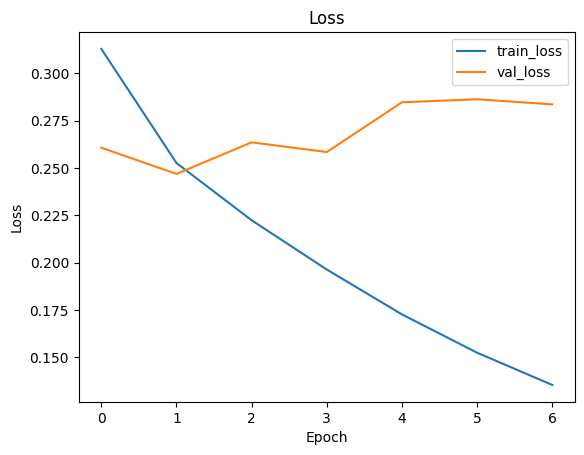

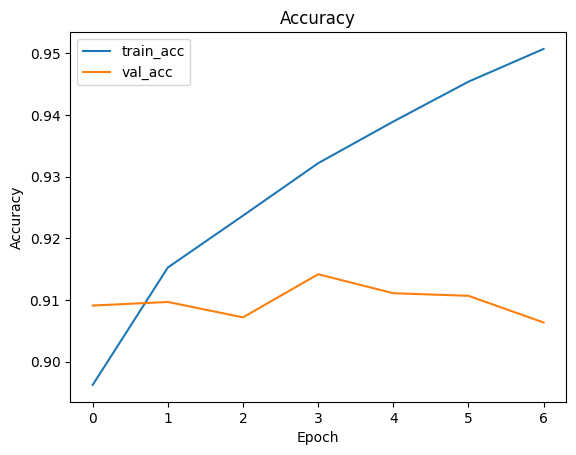

In [141]:
# ---- Training curves
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend(); plt.show()